In [118]:
import sys
sys.path.append("../")

from config import Config
conf = Config()

from utils.resource_manager import ResourceManager
resource_manager = ResourceManager.get_instance()

import os
from langchain.embeddings import init_embeddings


from typing import Optional 
import pandas as pd

from langgraph.graph import START, END, MessagesState, StateGraph

from langchain_core.tools import tool


from langgraph.prebuilt import create_react_agent, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from langgraph.graph.message import add_messages


from typing import Literal
from pydantic import BaseModel, Field

######### ENV #########
from dotenv import load_dotenv

from datetime import datetime, timedelta
from typing import Literal, Optional
from enum import Enum


load_dotenv()


True

In [119]:

class MemoryResponse(BaseModel):
    """Respond to the user with this"""
    AImessage : str = Field(description="Final AI Message confirming the user deleted the memory. Mention the exact memory which was forgotten as well")
    index_title : str = Field(description="index title of the memory to be deleted should be exactly as extracted by the tool : extract_specific_memory_from_all_memory from the memory string")
    remember_flag: str = Field(description= "Return exactly : Permanent or Not Permanent or None (if no memory) - from type of memory you want to forget")


class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: MemoryResponse


class TimePeriod(str, Enum):
    MINUTE = "minute"
    HOUR = "hour"
    DAY = "day"
    WEEK = "week"
    MONTH = "month"
    YEAR = "year"
    PERMANENTLY = "permanently"
    SPECIFIC_DATE = "specific_date"
    SPECIFIC_DAY = "specific_day"


@tool
def extract_specific_memory_from_all_memories(context: str):
    """Get the exact memory you want to forget"""
    return context


@tool
def extract_index_title_of_the_specific_memory(index_title: str):
    """Get the index title of the memory you want to forget. Dont create your own. Extract exactly as listed in the json for that specific memory"""
    return index_title


tools = [extract_specific_memory_from_all_memories,  extract_index_title_of_the_specific_memory, MemoryResponse]

remember_model =  conf.model.bind_tools(tools, tool_choice="any")

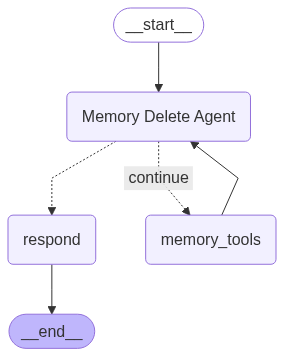

In [ ]:
# Define the function that calls the model
def call_model(state: AgentState):
    
    if state['messages'][0].type == 'human':
        permanent_memory= pd.read_csv(f"{conf.memory_path}/Permanent_Memory.csv")
        reminders = pd.read_csv(f"{conf.memory_path}/Reminders.csv")

        permanent_memory_str = permanent_memory.to_json(orient='records', indent=4)
        reminders_str = reminders.to_json(orient='records', indent=4)

        all_memory_str = f"\n\n<Permanent Memories>\n\n{permanent_memory_str}\n\n<Reminders>\n\n{reminders_str}"
        state["messages"][0].content = state["messages"][0].content + all_memory_str


    response = remember_model.invoke(state["messages"])

    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
def respond(state: AgentState):
    permanent_memory = pd.DataFrame()
    reminders = pd.DataFrame()
    permanent_path = f"{conf.memory_path}/Permanent_Memory.csv"
    reminders_path =  f"{conf.memory_path}/Reminders.csv"

    if os.path.exists(permanent_path):
        permanent_memory= pd.read_csv(permanent_path)

    if os.path.exists(reminders_path):
        reminders = pd.read_csv(reminders_path)
        
    # Construct the final answer from the arguments of the last tool call
    memory_tool_call = state["messages"][-1].tool_calls[0]
    response = MemoryResponse(**memory_tool_call["args"])
    # Since we're using tool calling to return structured output,
    # we need to add  a tool message corresponding to the MemoryResponse tool call,
    # This is due to LLM providers' requirement that AI messages with tool calls
    # need to be followed by a tool message for each tool call
    # Create final AI message instead of tool message
    ai_message = AIMessage(
        content=response.AImessage,
        response_metadata={"final_response": response.model_dump()}
    )
    # We return the final answer

    
    path = reminders_path
    central_memory = reminders

    
    if response.remember_flag.lower() != None:
        if response.remember_flag.lower() == 'permanent':
            path = permanent_path
            central_memory = permanent_memory

        memory_index = central_memory[central_memory['index_title']==response.index_title].index
        central_memory = central_memory.drop(memory_index) 

        central_memory.to_csv(path, index=False)
    return {"final_response": response, "messages": [ai_message]}

   


# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    # If there is only one tool call and it is the response tool call we respond to the user
    if (last_message.tool_calls[0]["name"] == "MemoryResponse"
    ):
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"
    


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("Memory Delete Agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("memory_tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("Memory Delete Agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "Memory Delete Agent",
    should_continue,
    {
        "continue": "memory_tools",
        "respond": "respond",
    },
)

workflow.add_edge("memory_tools", "Memory Delete Agent")
workflow.add_edge("respond", END)

memory_delete_agent = workflow.compile()
memory_delete_agent.name = 'Memory Delete Agent'


In [123]:
inputs = {"messages": [("user", "Forget my name")]}
result = resource_manager.stream_agent(memory_delete_agent.stream(inputs, stream_mode="values"))


================================ Human Message =================================

Forget my name
content='' additional_kwargs={'tool_calls': [{'id': 'call_LoqN9ZhSy8DaYtLRGqgIAcCl', 'function': {'arguments': '{"context":"Remember my name"}', 'name': 'extract_specific_memory_from_all_memories'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 545, 'total_tokens': 566, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BnUOWAAwuU3OkL3fL3OerOMarLypb', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--0934a2dd-36ad-4abd-9f31-d76bb18786f1-0' tool_calls=[{'name': 'extract_specific_memory_from_all_memories', 'args': {'context': 'Remember my name'}, 'i